In [1]:
%matplotlib inline
# %matplotlib notebook
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import datetime
import glob
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from scipy.stats import ttest_ind, sem
import collections
import matplotlib.ticker as plticker

C:\Users\likkhian\Anaconda3\lib\site-packages\xarray\conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


## Define monthly baseflow
To be used in comparing ratios of streamflows

In [2]:
# monthly baseflows. Actually, I just need chiang saen as an example of bounday condition inflow.
baseflow=pd.DataFrame()
baseflow['Chiang Saen']=[1150,930,830,910,1300,2460,4720,6480,5510,3840,2510,1590]
# baseflow['Luang Prabang']=[1690,1280,1060,1110,1570,3110,6400,9920,8990,5750,3790,2400]
# baseflow['Vientiane']=[1760,1370,1170,1190,1720,3410,6920,11000,10800,6800,4230,2560]
# baseflow['Nakhon Phanom']=[2380,1860,1560,1530,2410,6610,12800,19100,18500,10200,5410,3340]
# baseflow['Mukdahan']=[2370,1880,1600,1560,2430,7090,13600,20600,19800,10900,5710,3410]
# baseflow['Pakse']=[2800,2170,1840,1800,2920,8810,16600,26200,26300,15400,7780,4190]
# baseflow['Kratie']=[3620,2730,2290,2220,3640,11200,22200,35500,36700,22000,10900,5710]

print(baseflow)

    Chiang Saen
0          1150
1           930
2           830
3           910
4          1300
5          2460
6          4720
7          6480
8          5510
9          3840
10         2510
11         1590


## Read and prep data
Read frxst_pts_out files, combines them into two dataframes,  
then adds columns describing the station name and their order  
in the lower Mekong River

In [7]:
# directory='C:/Users/likkhian/SkyDrive/Thesis/wrfhydro_output/'
directory='../wrfhydro_output/'
df1=pd.read_csv(directory+'frxst_full_s2000.csv',dayfirst=True,header=0)
df1['datetime']=pd.to_datetime(df1['datetime'])
df2=pd.read_csv(directory+'frxst_full_eas0c.csv',dayfirst=True,header=0)
df2['datetime']=pd.to_datetime(df2['datetime'])

'''Everything below is used to create the df that is saved in frxst_full_*.csv'''
# files_2000=['frxst_pts_out_2000_01','frxst_pts_out_2000_02','frxst_pts_out_2000_03']
# files_eas0c=['frxst_pts_out_eas0c_01','frxst_pts_out_eas0c_02','frxst_pts_out_eas0c_03']

# def readtable(fileloc):
#     df=pd.read_table(fileloc,delimiter=",",header=None)
#     df.columns=['s in simulation','datetime','stationID','lon','lat', \
#     'discharge m3s','discharge ft3s','depth']
#     df['datetime']=pd.to_datetime(df['datetime'])
#     return df
def makefilename(var):
    return directory+var+'.txt'
# def combine_files(file_list):
#     df=readtable(makefilename(file_list[0]))
#     df2 = pd.concat([df,readtable(makefilename(file_list[1]))])
#     df3 = pd.concat([df2,readtable(makefilename(file_list[2]))])
#     return df3
# def label_station(row):
#     '''
#     This function reorders stations in the order they are encountered
#     starting from the mouth of the lower Mekong River, and travelling upstream
#     '''
# #     if ((abs(row['lon']-105.24291)<0.01) & (abs(row['lat']-10.80413)<0.01)):
#     if (row['stationID'] == 0):
#         return 'Tan Chau'
# #     if ((abs(row['lon']-105.28458)<0.01) & (abs(row['lat']-11.26228)<0.01)):
#     if (row['stationID'] == 1):
#         return 'Neak Loung'
# #     if ((abs(row['lon']-104.95117)<0.01) & (abs(row['lat']-11.56459)<0.01)):
#     if (row['stationID'] == 2):
#         return 'Phnom Penh'
# #     if ((abs(row['lon']-104.80947)<0.01) & (abs(row['lat']-11.80947)<0.01)):
#     if (row['stationID'] == 3):
#         return 'Prek Kdam'
# #     if ((abs(row['lon']-105.47630)<0.01) & (abs(row['lat']-11.98890)<0.01)):
#     if (row['stationID'] == 4):
#         return 'Kampong Cham'
# #     if ((abs(row['lon']-106.01810)<0.01) & (abs(row['lat']-12.46953)<0.01)):
#     if (row['stationID'] == 5):
#         return 'Kratie'
# #     if ((abs(row['lon']-105.94308)<0.01) & (abs(row['lat']-13.52535)<0.01)):
#     if (row['stationID'] == 6):
#         return 'Stung Treng'
# #     if ((abs(row['lon']-105.81805)<0.01) & (abs(row['lat']-15.10829)<0.01)):
#     if (row['stationID'] == 7):
#         return 'Pakse'
# #     if ((abs(row['lon']-105.56799)<0.01) & (abs(row['lat']-15.32545)<0.01)):
#     if (row['stationID'] == 8):
#         return 'Khong Chiam'
# #     if ((abs(row['lon']-104.75113)<0.01) & (abs(row['lat']-16.52774)<0.01)):
#     if (row['stationID'] == 9):
#         return 'Mukdahan'
# #     if ((abs(row['lon']-104.80113)<0.01) & (abs(row['lat']-17.38086)<0.01)):
#     if (row['stationID'] == 10):
#         return 'Thakhek'
# #     if ((abs(row['lon']-102.71729)<0.01) & (abs(row['lat']-17.87338)<0.01)):
#     if (row['stationID'] == 11):
#         return 'Nongkhai' #12
# #     if ((abs(row['lon']-101.65870)<0.01) & (abs(row['lat']-17.88925)<0.01)):
#     if (row['stationID'] == 12):
#         return 'Chiang Khan' #14
# #     if ((abs(row['lon']-102.61726)<0.01) & (abs(row['lat']-17.92097)<0.01)):
#     if (row['stationID'] == 13):
#         return 'Vientiane' #13
# #     if ((abs(row['lon']-103.65919)<0.01) & (abs(row['lat']-18.37246)<0.01)):
#     if (row['stationID'] == 14):
#         return 'Paksane' #11
# #     if ((abs(row['lon']-102.05046)<0.01) & (abs(row['lat']-19.86875)<0.01)):
#     if (row['stationID'] == 15):
#         return 'Luang Prabang'
# #     if ((abs(row['lon']-102.56725)<0.01) & (abs(row['lat']-20.52587)<0.01)):
#     if (row['stationID'] == 16):
#         return 'ChiangSaen'

# def station_order(row):
#     '''
#     This function reorders stations in the order they are encountered
#     starting from the mouth of the lower Mekong River, and travelling upstream
#     '''
#     if (row['stationID'] == 0):
#         return 0
#     if (row['stationID'] == 1):
#         return 1
#     if (row['stationID'] == 2):
#         return 2
#     if (row['stationID'] == 3):
#         return 3
#     if (row['stationID'] == 4):
#         return 4
#     if (row['stationID'] == 5):
#         return 5
#     if (row['stationID'] == 6):
#         return 6
#     if (row['stationID'] == 7):
#         return 7
#     if (row['stationID'] == 8):
#         return 8
#     if (row['stationID'] == 9):
#         return 9
#     if (row['stationID'] == 10):
#         return 10
#     if (row['stationID'] == 11):
#         return 12 #12
#     if (row['stationID'] == 12):
#         return 14 #14
#     if (row['stationID'] == 13):
#         return 13 #13
#     if (row['stationID'] == 14):
#         return 11 #11
#     if (row['stationID'] == 15):
#         return 15
#     if (row['stationID'] == 16):
#         return 16

C:\Users\likkhian\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# #save to csv
# df1.to_csv(directory+'frxst_full_s2000.csv')
# df2.to_csv(directory+'frxst_full_eas0c.csv')

In [4]:
%%time
# df1=combine_files(files_2000)
# df2=combine_files(files_eas0c)
# print('adding station name and order...')
# # print(zip(*df1.iloc[:10,:].apply(label_station,axis=1)))
# df1['station name']=df1.apply(label_station,axis=1)
# print('next')
# df1['order']=df1.apply(station_order,axis=1)
# print('next')
# df2['station name']=df2.apply(label_station,axis=1)
# print('next')
# df2['order']=df2.apply(station_order,axis=1)
print(df1.describe())
print(df1[['stationID','lon','lat','station name','order']].iloc[:17])
print(df1.columns.values)
base=datetime.datetime(2090,1,1)
time=np.array([base + datetime.timedelta(hours=i) for i in range(len(df1.loc[df1['stationID']==3]))])

         Unnamed: 0     stationID           lon           lat  discharge m3s  \
count  1.788264e+06  1.788264e+06  1.788264e+06  1.788264e+06   1.788264e+06   
mean   2.980435e+05  8.000000e+00  1.043491e+02  1.530690e+01   4.523653e+03   
std    1.720758e+05  4.898981e+00  1.428489e+00  3.148021e+00   8.821659e+03   
min    0.000000e+00  0.000000e+00  1.016587e+02  1.080413e+01  -3.879438e+03   
25%    1.490218e+05  4.000000e+00  1.027173e+02  1.198890e+01   3.108400e+01   
50%    2.980435e+05  8.000000e+00  1.048095e+02  1.532545e+01   5.233560e+02   
75%    4.470652e+05  1.200000e+01  1.054763e+02  1.788925e+01   4.985259e+03   
max    5.960870e+05  1.600000e+01  1.060181e+02  2.052587e+01   2.749985e+05   

       discharge ft3s         depth         order  
count    1.788264e+06  1.788264e+06  1.788264e+06  
mean     1.597528e+05  5.096883e+00  8.000000e+00  
std      3.115369e+05  4.950736e+00  4.898981e+00  
min     -1.370023e+05  1.000000e-03  0.000000e+00  
25%      1.097742e+

## Plots
### Calculating monthly flowrates for each station

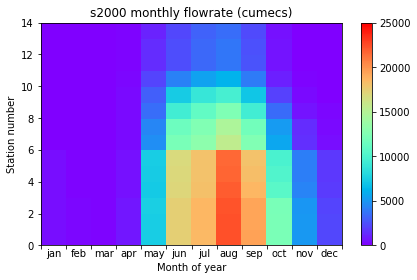

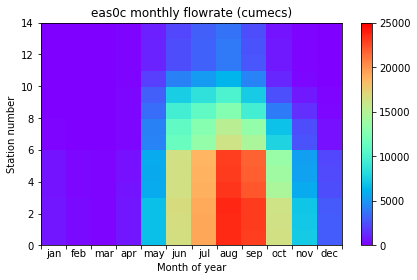

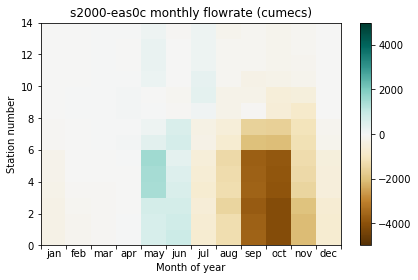

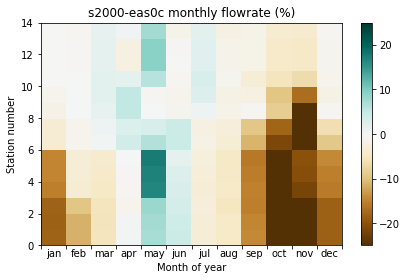

In [20]:
#calculate monthly rates
from matplotlib import ticker
stations=df1['stationID'].unique()
def mergetime(data,ii): #function to extract hourly timeseries from a single station
    station=data.loc[data['order']==ii][['datetime','discharge m3s']].copy() #extract by order instead of station number
    return station

def daily(data,stn): #to calculate daily data
    station_hourly=mergetime(data,stn)
    station_daily = station_hourly.resample('D',on='datetime').mean()
    return station_daily
    
def yearly(data,stn): # function to calculate mean for each year
    station_data=mergetime(data,stn)
    station_data=np.mean(station_data.reshape([-1,24]),axis=1)
    daycut=0
    out=[]
    for i in range(1,13):
        if (i+2%4):
            out.append(np.mean(station_data[daycut:daycut+366]))
            daycut+=366
        else:
            out.append(np.mean(station_data[daycut:daycut+365]))
            daycut+=365
    return np.array(out)

def group_mth(data,stn):
    station_hourly=mergetime(data,stn)
    grouped=station_hourly.groupby(station_hourly['datetime'].dt.month).mean()
    return grouped['discharge m3s']
# idd=9
# test1=group_mth(df1,idd)
# print(test1)
# print(df1.sample(1))
# test2=yearly(df2,idd)
# print(sem(test1))
# plt.plot(test1)
# plt.plot(test2)
test1=np.empty([14,12])
test2=np.empty([14,12])
inx=0
for idd in range(0,17):
    if (idd != 3) & (idd <15):
#         print(inx)
        test1[inx,:]=group_mth(df1,idd)
        test2[inx,:]=group_mth(df2,idd)
        inx+=1
def maketick():
    ax=plt.gca()
    month_name=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(month_name))
    ax.tick_params(axis='x',which='minor',length=0)
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

test1a=np.empty(np.shape(test1)) # for relative difference, include baseflow.
for i in range(0,14):
    test1a[i,:]=test1[i,:]+baseflow.T

plt.rcParams["figure.figsize"] = 6,4
plt.figure(1)
plt.pcolormesh((test1),cmap='rainbow',vmin=0,vmax=25000)
maketick()
plt.colorbar()
plt.title('s2000 monthly flowrate (cumecs)')
plt.ylabel('Station number')
plt.xlabel('Month of year')
plt.tight_layout()
plt.figure(2)
plt.pcolormesh((test2),cmap='rainbow',vmin=0,vmax=25000)
maketick()
plt.colorbar()
plt.title('eas0c monthly flowrate (cumecs)')
plt.ylabel('Station number')
plt.xlabel('Month of year')
plt.tight_layout()
plt.figure(3)
plt.pcolormesh(test1-test2,vmin=-5000,vmax=5000,cmap='BrBG')
maketick()
plt.colorbar()
plt.title('s2000-eas0c monthly flowrate (cumecs)')
plt.ylabel('Station number')
plt.xlabel('Month of year')
plt.tight_layout()
plt.figure(4)
plt.pcolormesh((test1-test2)/test1a*100,vmin=-25,vmax=25,cmap='BrBG')
maketick()
plt.colorbar()
plt.title('s2000-eas0c monthly flowrate (%)')
plt.ylabel('Station number')
plt.xlabel('Month of year')
plt.tight_layout()
plt.show()

[[ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830.   910.  1300.  2460.  4720.  6480.  5510.  3840.
   2510.  1590.]
 [ 1150.   930.   830

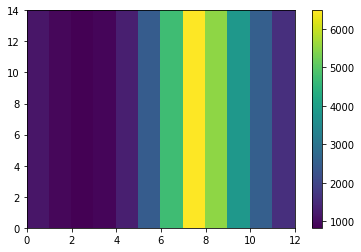

In [7]:
np.shape(test1)
test1a=np.empty(np.shape(test1))
for i in range(0,14):
    test1a[i,:]=test1[i,:]+baseflow.T
print(test1a-test1)
plt.pcolormesh((test1a-test1))
plt.colorbar()
plt.show()

## Plot overall means
### Print mean for each station

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0 Tan Chau,8926.65
1 Neak Loung,8924.90
2 Phnom Penh,8899.66
3 Prek Kdam,372.89
4 Kampong Cham,8514.17
5 Kratie,8365.95
6 Stung Treng,8304.45
7 Pakse,5556.28
8 Khong Chiam,5246.74
9 Mukdahan,4271.17
10 Thakhek,3269.46
11 Paksane,1233.56
12 Nongkhai,1112.52
13 Vientiane,1221.83
14 Chiang Khan,1971.36
15 Luang Prabang,708.64
16 ChiangSaen,1.88


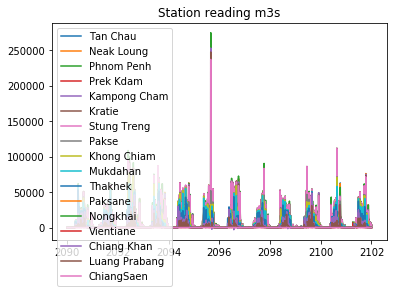

0 Tan Chau,9886.89
1 Neak Loung,9884.90
2 Phnom Penh,9876.76
3 Prek Kdam,506.57
4 Kampong Cham,9335.78
5 Kratie,9175.47
6 Stung Treng,9113.76
7 Pakse,6003.31
8 Khong Chiam,5630.39
9 Mukdahan,4408.05
10 Thakhek,3373.65
11 Paksane,1241.37
12 Nongkhai,1130.50
13 Vientiane,1229.76
14 Chiang Khan,1993.02
15 Luang Prabang,749.94
16 ChiangSaen,2.93


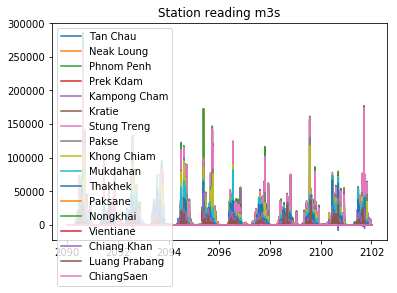

In [10]:
stationNames=('Tan Chau','Neak Loung','Phnom Penh','Prek Kdam','Kampong Cham', \
'Kratie','Stung Treng','Pakse','Khong Chiam','Mukdahan','Thakhek','Paksane', \
'Nongkhai','Vientiane','Chiang Khan','Luang Prabang','ChiangSaen') #correct order

def plt_stn(df):
    stations=df['stationID'].unique()
    for ii in (stations):
        plt.plot(time,df.loc[df['stationID']==ii]['discharge m3s'],label=stationNames[ii])
        print(ii,'{},{:.2f}'.format(stationNames[ii],np.mean(df.loc[df['stationID']==ii]['discharge m3s'])))
    plt.title('Station reading m3s')
    plt.legend(loc='upper left')
    plt.show()
print(stations)
plt_stn(df1)
plt_stn(df2)

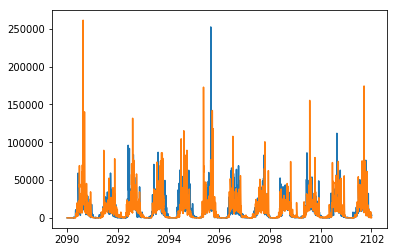

In [11]:
idd=0
plt.plot(time,df1.loc[df1['stationID']==idd]['discharge m3s'],label=stationNames[idd])
plt.plot(time,df2.loc[df2['stationID']==idd]['discharge m3s'],label=stationNames[idd])
plt.show()

#### calculate mean difference

In [12]:
from scipy.stats import sem
def get_mean(df):
    stdd=[] #standard deviation
    mean=[]
    lats=[]
    lons=[]
    stations=df['stationID'].unique()
    print(stations)
    for ii in (stations):
        if (ii != 3) & (ii <15) :
            mean.append(np.mean(df.loc[df['order']==ii]['discharge m3s']))
            stdd.append(sem(df.loc[df['order']==ii]['discharge m3s']))
            lons.append(df.loc[df['order']==ii]['lon'].iloc[0])
            lats.append(df.loc[df['order']==ii]['lat'].iloc[0])
    return mean,stdd,lons,lats
mean_2000,std_2000,lons,lats=np.array(get_mean(df1))
mean_eas0c,std_eas0c,lons,lats=np.array(get_mean(df2))
diff=mean_2000-mean_eas0c
ratio=diff/mean_2000
std=((std_2000**2)+std_eas0c**2)**0.5
std_ratio=std/mean_2000*100
print(diff,ratio)
print(std)
print(std_ratio)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[-960.24339159 -960.00729247 -977.10361872 -821.61586007 -809.51778795
 -809.31460779 -447.03505278 -383.65220798 -136.8864456  -104.19125161
  -21.66224266   -7.80400252   -7.93584772  -17.97821793] [-0.10757043 -0.1075651  -0.10979113 -0.09649987 -0.09676336 -0.09745559
 -0.08045583 -0.07312203 -0.03204895 -0.03186807 -0.01098847 -0.00632638
 -0.00649507 -0.0161599 ]
[ 58.83298757  58.8517671   59.32930835  56.85142233  56.26024192
  55.92027543  39.99561924  38.02196095  31.39163651  24.65176209
  15.49994518  10.33079017  10.28279632   9.77842063]
[ 0.65907144  0.65941125  0.66664698  0.66772748  0.67249045  0.67337763
  0.71982739  0.72467794  0.73496615  0.75400194  0.78625616  0.83747464
  0.84159214  0.87894331]


[-960.24339159 -960.00729247 -977.10361872 -821.61586007 -809.51778795
 -809.31460779 -447.03505278 -383.65220798 -136.8864456  -104.19125161
   -7.80400252  -17.97821793   -7.93584772  -21.66224266]  
   [-0.10757043 -0.1075651  -0.10979113 -0.09649987 -0.09676336 -0.09745559
 -0.08045583 -0.07312203 -0.03204895 -0.03186807 -0.00632638 -0.0161599
 -0.00649507 -0.01098847]  
[ 58.83298757  58.8517671   59.32930835  56.85142233  56.26024192
  55.92027543  39.99561924  38.02196095  31.39163651  24.65176209
  10.33079017   9.77842063  10.28279632  15.49994518]  
[ 0.65907144  0.65941125  0.66664698  0.66772748  0.67249045  0.67337763
  0.71982739  0.72467794  0.73496615  0.75400194  0.83747464  0.87894331
  0.84159214  0.78625616]

[1506, 1450, 1387, 1289, 1174, 1044, 839, 804, 596, 491, 320, 167, 137, 0]


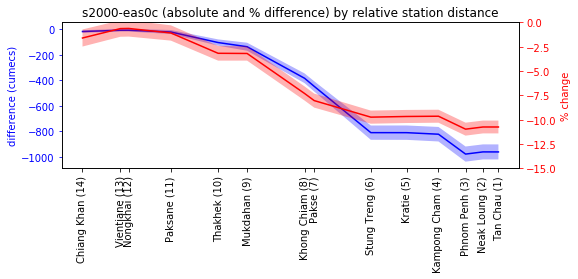

In [13]:
# station_dist={'ChiangSaen':0,'Luang Prabang':104,'Paksane':415,'Vientiane':552,'Chiang Khan':582,\
#              'Nongkhai':735,'Thakhek':906,'Mukdahan':1011,'Khong Chiam':1219,'Pakse':1254, \
#              'Stung Treng':1459,'Kratie':1589,'Kampong Cham':1704,'Prek Kdam':1827,'Phnom Penh':1802, \
#              'Neak Loung':1865,'Tan Chau':1921}
station_dist2=collections.OrderedDict([('Chiang Khan (14)',0),('Vientiane (13)',137),('Nongkhai (12)',167),\
             ('Paksane (11)',320),('Thakhek (10)',491),('Mukdahan (9)',596),('Khong Chiam (8)',804),('Pakse (7)',839), \
             ('Stung Treng (6)',1044),('Kratie (5)',1174),('Kampong Cham (4)',1289),('Phnom Penh (3)',1387), \
             ('Neak Loung (2)',1450),('Tan Chau (1)',1506)])
distances=[]
tickname=[]
for i,ii in enumerate(station_dist2):
    distances.append(station_dist2[ii])
    tickname.append(ii)
distances.sort(reverse=True)
tickname=tickname[::-1]

print(distances)

plt.rcParams["figure.figsize"] = 8,4
ax1=plt.subplot()
ax1.plot(distances,diff,'b')
ax1.fill_between(distances,diff-std,diff+std,alpha=0.3,facecolor='blue')
# ax1.set_xlabel('Grid distance from first station (grid points)')
ax1.set_ylabel('difference (cumecs)', color='b')
ax1.tick_params('y', colors='b')
plt.xticks(distances,tickname,rotation='90')
ax2=plt.twinx()
ax2.plot(distances,ratio*100,'r')
ax2.fill_between(distances,ratio*100-std_ratio,ratio*100+std_ratio,alpha=0.3,facecolor='red')
ax2.set_ylabel('% change',color='r')
ax2.set_ylim([-15,0])
ax2.tick_params('y',colors='r')
plt.title('s2000-eas0c (absolute and % difference) by relative station distance')
plt.tight_layout()
plt.show()

Plot locations of stations and the overall differences in mean flow rate underlaid with DEM data

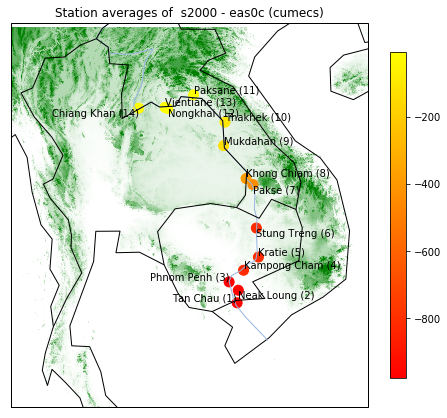

In [25]:
#import DEM data
fulldom=xr.open_dataset('../HydrologySection/wrfhydroInputs/Fulldom_hiresD.nc')

from adjustText.adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['figure.figsize'] = 8, 10
stationNames2=('Tan Chau (1)','Neak Loung (2)','Phnom Penh (3)','Kampong Cham (4)', \
'Kratie (5)','Stung Treng (6)','Pakse (7)','Khong Chiam (8)','Mukdahan (9)','Thakhek (10)','Paksane (11)', \
'Nongkhai (12)','Vientiane (13)','Chiang Khan (14)')

ax = plt.axes(projection=ccrs.PlateCarree())
mycmap = LinearSegmentedColormap.from_list('mycmap',['white','green'])
ax.pcolormesh(fulldom.LONGITUDE,fulldom.LATITUDE,fulldom.TOPOGRAPHY,cmap=mycmap,vmin=0,vmax=1500)
ax.scatter(lons,lats,c=diff,marker='o',s=100,cmap='autumn')
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.BORDERS)
# ax.stock_img()
ax.set_extent([97, 110, 7, 21])

# for i, txt in enumerate(stationNames2):
#     ax.annotate(txt, (lons[i],lats[i]),fontsize='8')
# make the station names not overlap
texts=[]
for x, y, s in zip(lons, lats, stationNames2):
    texts.append(plt.text(x, y, s))
adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1))
# PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
for PCM in ax.get_children(): 
    if type(PCM) == matplotlib.collections.PathCollection: break
plt.colorbar(PCM, ax=ax, shrink=0.6)
ax.set_title('Station averages of  s2000 - eas0c (cumecs)')
plt.show()

In [ ]:
stations=df1['stationID'].unique()
names=df1['station name'].unique()
for ii in stations:
    print(ii,names[ii],ttest_ind(df1.loc[df1['stationID']==ii]['discharge m3s'],df2.loc[df2['stationID']==ii]['discharge m3s']))

### Mass balance
Looking at qstrmvolrt, and maybe comparing it to ppt output? 

In [89]:
files_qstrm_2000=['qstrmvolrt_accum_2000_01','qstrmvolrt_accum_2000_02','qstrmvolrt_accum_2000_03']
files_qstrm_eas0c=['qstrmvolrt_accum_eas0c_01','qstrmvolrt_accum_eas0c_02','qstrmvolrt_accum_eas0c_03']
qstrm_2000_1=np.loadtxt(makefilename(files_qstrm_2000[0]))
qstrm_2000_2=np.loadtxt(makefilename(files_qstrm_2000[1]))
qstrm_2000_3=np.loadtxt(makefilename(files_qstrm_2000[2]))
qstrm_eas0c_1=np.loadtxt(makefilename(files_qstrm_eas0c[0]))
qstrm_eas0c_2=np.loadtxt(makefilename(files_qstrm_eas0c[1]))
qstrm_eas0c_3=np.loadtxt(makefilename(files_qstrm_eas0c[2]))

(43912,)


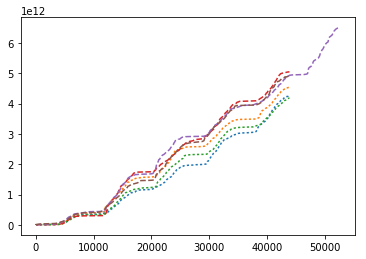

In [80]:
print(np.shape(qstrm_2000_1))
plt.plot(qstrm_2000_1,':')
plt.plot(qstrm_2000_2,':')
plt.plot(qstrm_2000_3,':')
plt.plot(qstrm_eas0c_1,'--')
plt.plot(qstrm_eas0c_2,'--')
plt.plot(qstrm_eas0c_3,'--')
plt.show()

In [87]:
def find_drops(qstrm_test):
    lgst=0
    extras=[]
    new=[]
    for ii in range(1,len(qstrm_test)):
        if (lgst >= qstrm_test[ii]):
            extras.append(ii)
        else:
            lgst=qstrm_test[ii]
            new.append(qstrm_test[ii])
    print(len(qstrm_test),len(extras),len(qstrm_test)-len(extras))
    return np.array(new)

In [90]:
qstrm_2000_1=find_drops(qstrm_2000_1)
qstrm_2000_2=find_drops(qstrm_2000_2)
qstrm_2000_3=find_drops(qstrm_2000_3)
qstrm_eas0c_1=find_drops(qstrm_eas0c_1)
qstrm_eas0c_2=find_drops(qstrm_eas0c_2)
qstrm_eas0c_3=find_drops(qstrm_eas0c_3)

43912 87 43825
44081 112 43969
43868 43 43825
43867 43 43824
52636 114 52522
43876 70 43806


In [91]:
def deaccum(qstrm):
    return qstrm[1:]-qstrm[:-1]

In [92]:
s1_1=deaccum(qstrm_2000_1)
print(sum(s1_1>0))

43823


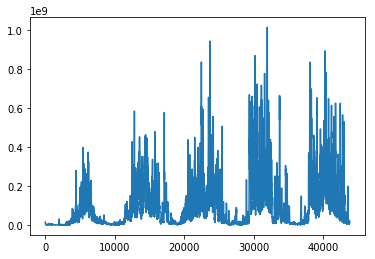

In [93]:
plt.plot(s1_1[10:])